<a href="https://colab.research.google.com/github/niedakaito/EU_M_Math/blob/main/MatPlotlib_%26_Plotly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MatPlotlib

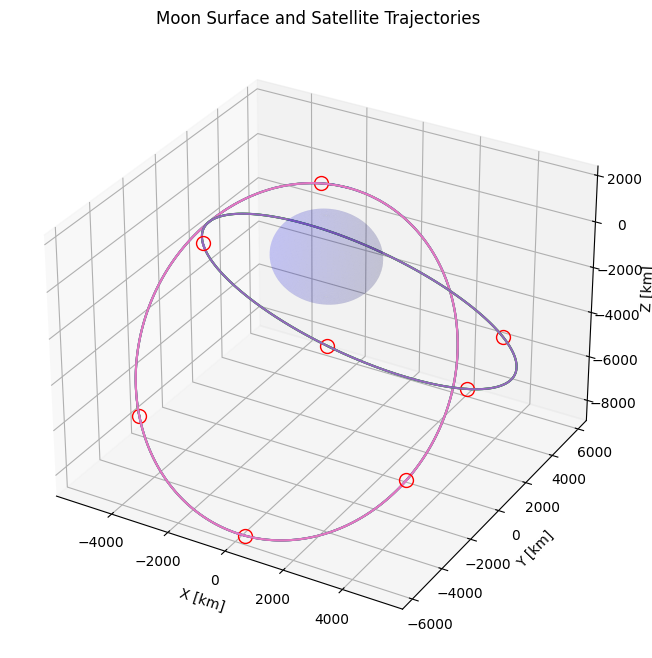

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants and initial values
d2r = np.pi / 180
a = 6540e3  # Semi-major axis [m]
ecc = 0.6  # Eccentricity
inc = 56.3 * d2r  # Inclination [rad]
w = 90 * d2r  # Argument of perigee [rad]
RAAN = np.array([0, 0, 0, 0, 180, 180, 180, 180]) * d2r  # Right ascension of ascending node [rad]
M0 = np.array([0, 90, 180, 270, 45, 135, 225, 315]) * d2r  # Mean anomaly at epoch [rad]

# Satellite vehicle number
satID = np.arange(1, 9)
nsv = len(satID)

# Rover location (Lunar south pole)
rm = 1737.4e3  # Lunar radius [m]
r_station = np.array([-6516.5, 7990.0, -1737469.4])  # Rover location [m]

# Convert latitude and longitude to radians
lat = -89.66 * d2r
lon = 129.2 * d2r

# Up-East-North rotation matrix
def roty(theta):
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([[c, 0, -s],
                     [0, 1, 0],
                     [s, 0, c]])

def rotz(theta):
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([[c, s, 0],
                     [-s, c, 0],
                     [0, 0, 1]])

M = np.dot(roty(-lat), rotz(lon))

# Time since epoch [sec]
dt = np.arange(0, 801, 5) * 60  # [s]
nt = len(dt)

# LNSS satellite position and visibility
xyz = np.ones((nt, 3, nsv))
allAz = np.full((nt, nsv), np.nan)
allEl = np.full((nt, nsv), np.nan)

# Keplerian orbital parameters and visibility calculation
def kepler(a, ecc, inc, RAAN, w, M0, dt):
    n = np.sqrt(6.67430e-11 * 7.342e22 / (a ** 3))  # Mean motion
    M = M0 + n * dt  # Mean anomaly
    E = M
    for _ in range(10):
        E = M + ecc * np.sin(E)
    nu = 2 * np.arctan(np.sqrt((1 + ecc) / (1 - ecc)) * np.tan(E / 2))  # True anomaly
    r = a * (1 - ecc ** 2) / (1 + ecc * np.cos(nu))  # Orbital radius
    r_sat = np.array([
        r * (np.cos(RAAN) * np.cos(w + nu) - np.sin(RAAN) * np.sin(w + nu) * np.cos(inc)),
        r * (np.sin(RAAN) * np.cos(w + nu) + np.cos(RAAN) * np.sin(w + nu) * np.cos(inc)),
        r * (np.sin(w + nu) * np.sin(inc))
    ])
    v_sat = np.sqrt(6.67430e-11 * 7.342e22 / (a * (1 - ecc ** 2))) * np.array([
        -np.sin(w + nu),
        np.cos(w + nu) * np.cos(inc),
        np.sin(w + nu) * np.sin(inc)
    ])
    return r_sat, v_sat

# Calculate satellite positions and visibility
for i in range(nt):
    for sv in range(nsv):
        r_sat, v_sat = kepler(a, ecc, inc, RAAN[sv], w, M0[sv], dt[i])
        xyz[i, :, sv] = r_sat / 1000  # Convert to km

        s = np.dot(M, (r_sat - r_station))
        az = np.arctan2(s[0], s[1])  # Azimuth
        el = np.arcsin(s[2] / np.linalg.norm(s))  # Elevation

        allAz[i, sv] = np.degrees(az)
        allEl[i, sv] = np.degrees(el)

# Plot satellite trajectories
fig1 = plt.figure(figsize=(10, 8))
ax1 = fig1.add_subplot(111, projection='3d')

# Moon surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
X = rm * np.outer(np.cos(u), np.sin(v))
Y = rm * np.outer(np.sin(u), np.sin(v))
Z = rm * np.outer(np.ones(np.size(u)), np.cos(v))
ax1.plot_surface(X / 1000, Y / 1000, Z / 1000, color='b', alpha=0.1)

ax1.set_xlabel('X [km]')
ax1.set_ylabel('Y [km]')
ax1.set_zlabel('Z [km]')
ax1.set_title('Moon Surface and Satellite Trajectories')

# Satellite trajectories
for sv in range(nsv):
    ax1.plot(xyz[:, 0, sv], xyz[:, 1, sv], xyz[:, 2, sv])
    ax1.plot([xyz[-1, 0, sv]], [xyz[-1, 1, sv]], [xyz[-1, 2, sv]], 'o', markersize=10,
             markerfacecolor='none', markeredgecolor='r')

# Plotly

In [2]:
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio

# Constants
d2r = np.pi / 180

# LNSS satellites parameters
a = 6540e3  # Semi-major axis [m]
ecc = 0.6  # Eccentricity
inc = 56.3 * d2r  # Inclination [rad]
w = 90 * d2r  # Argument of perigee [rad]
RAAN = np.array([0, 0, 0, 0, 180, 180, 180, 180]) * d2r  # Right ascension of ascending node [rad]
M0 = np.array([0, 90, 180, 270, 45, 135, 225, 315]) * d2r  # Mean anomaly at epoch [rad]

# Satellite vehicle number
satID = np.arange(1, 9)
nsv = len(satID)

# Rover location (Lunar south pole)
rm = 1737.4e3  # Lunar radius [m]
r_station = np.array([-6516.5, 7990.0, -1737469.4])

# Latitude and Longitude
lat = -89.66 * d2r
lon = 129.2 * d2r

# Rotation matrices
def roty(theta):
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([[c, 0, -s], [0, 1, 0], [s, 0, c]])

def rotz(theta):
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([[c, s, 0], [-s, c, 0], [0, 0, 1]])

M = roty(-lat) @ rotz(lon)

# Time since epoch [sec]
dt = np.arange(0, 801, 5) * 60  # T = 791 [min] = 13.2 [hour]
nt = len(dt)

# LNSS satellite position and visibility
xyz = np.ones((nt, 3, nsv))
allAz = np.full((nt, nsv), np.nan)
allEl = np.full((nt, nsv), np.nan)

# Keplerian to Cartesian conversion
def kepler(a, ecc, inc, RAAN, w, M0, t):
    mu = 4902.800066  # Moon's gravitational parameter, km^3/s^2
    n = np.sqrt(mu / a**3)  # Mean motion [rad/s]
    M = M0 + n * t  # Mean anomaly [rad]
    E = M  # Eccentric anomaly [rad] (initial guess)

    # Solve Kepler's equation iteratively
    for _ in range(10):
        E = M + ecc * np.sin(E)

    # True anomaly [rad]
    v = 2 * np.arctan2(np.sqrt(1 + ecc) * np.sin(E / 2), np.sqrt(1 - ecc) * np.cos(E / 2))

    # Radius
    r = a * (1 - ecc * np.cos(E))

    # Position in orbital plane
    x_op = r * np.cos(v)
    y_op = r * np.sin(v)
    z_op = 0

    # Rotate to inertial frame
    pos = np.array([x_op, y_op, z_op])
    R = rotz(-RAAN) @ roty(-inc) @ rotz(-w)
    pos = R @ pos

    return pos, np.zeros(3)

# Azimuth and Elevation calculation
def azel(s):
    az = np.arctan2(s[1], s[0])
    el = np.arcsin(s[2] / np.linalg.norm(s))
    return az, el

for i in range(nt):
    for sv in range(nsv):
        # Moon centered inertial position and velocity
        r_sat, v_sat = kepler(a, ecc, inc, RAAN[sv], w, M0[sv], dt[i])
        xyz[i, :, sv] = r_sat / 1000  # [km]

        # Satellite visibility
        s = M @ (r_sat - r_station)  # Local Up-East-North position
        az, el = azel(s)  # Azimuth and elevation [rad]

        allAz[i, sv] = az / d2r  # [deg]
        allEl[i, sv] = el / d2r  # [deg]

# Plot satellite trajectories using Plotly
theta = np.linspace(0, np.pi, 50)
phi = np.linspace(0, 2 * np.pi, 50)
theta, phi = np.meshgrid(theta, phi)
x_sphere = rm / 1000 * np.sin(theta) * np.cos(phi)
y_sphere = rm / 1000 * np.sin(theta) * np.sin(phi)
z_sphere = rm / 1000 * np.cos(theta)

fig = go.Figure()

# Add moon surface
fig.add_trace(go.Surface(x=x_sphere, y=y_sphere, z=z_sphere, colorscale='Blues', opacity=0.5))

# Add satellite trajectories
for sv in range(nsv):
    fig.add_trace(go.Scatter3d(x=xyz[:, 0, sv], y=xyz[:, 1, sv], z=xyz[:, 2, sv], mode='lines', name=f'Sat {satID[sv]}'))
    fig.add_trace(go.Scatter3d(x=[xyz[-1, 0, sv]], y=[xyz[-1, 1, sv]], z=[xyz[-1, 2, sv]], mode='markers', marker=dict(size=5), name=f'Sat {satID[sv]} end'))

# Update layout
fig.update_layout(
    scene=dict(
        xaxis_title='X [km]',
        yaxis_title='Y [km]',
        zaxis_title='Z [km]',
        aspectmode='data'
    ),
    title='LNSS Satellite Trajectories around the Moon'
)

# Show the plot
pio.show(fig)
